In [28]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import atomic.labels as lab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder,"atomic-features.h5")
labels_h5 = os.path.join(datafolder,"atomic-labels.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions.h5")

In [30]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "Premier League"]
traingames = games[games.season_name == "2017/2018"]
testgames = games[games.season_name == "2018/2019"]
print("nb of games:", len(traingames))

nb of games: 380


In [31]:
import xgboost
xgboost.__version__

'0.90'

In [39]:
soccerdata = os.path.join(datafolder, "soccerdata.h5")

xfns = [#fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.goalscore,
       fs.location,
       fs.polar,
       fs.direction,
       fs.team,
       fs.time,
       fs.time_delta
      ]
nb_prev_actions = 2

X = []
for game_id in tqdm.tqdm(traingames.game_id,desc="selecting features"):
    Xi = pd.read_hdf(features_h5,f"game_{game_id}")
    X.append(Xi)
X = pd.concat(X).reset_index(drop=True)

selecting features: 100%|██████████| 380/380 [00:04<00:00, 88.11it/s]


In [43]:
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X[Xcols].to_hdf(soccerdata,"features")

In [44]:
Y = []
for game_id in tqdm.tqdm(traingames.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
    Y.append(Yi)
Y = pd.concat(Y).reset_index(drop=True)

selecting label: 100%|██████████| 380/380 [00:03<00:00, 103.94it/s]


In [45]:
Y[["scores","concedes"]].to_hdf(soccerdata,"labels")

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1129613,False,False
1129614,False,False
1129615,False,False
1129616,False,False


In [6]:
# 1. Select feature set X
xfns = [#fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.goalscore,
       fs.location,
       fs.polar,
       fs.direction,
       fs.team,
       fs.time,
       fs.time_delta
      ]
nb_prev_actions = 2

Xcols = fs.feature_column_names(xfns,nb_prev_actions)

def getXY(games,Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
        Xi = pd.read_hdf(features_h5,f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores"]#,"concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
        Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X,Y

X,Y = getXY(traingames,Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))
X = X.fillna(0)

selecting label: 100%|██████████| 380/380 [00:05<00:00, 74.14it/s]


X: ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_receival_a0', 'type_out_a0', 'type_offside_a0', 'type_goal_a0', 'type_owngoal_a0', 'type_yellow_card_a0', 'type_red_card_a0', 'type_pass_a1', 'type_cross_a1', 'type_throw_in_a1', 'type_freekick_crossed_a1', 'type_freekick_short_a1', 'type_corner_crossed_a1', 'type_corner_short_a1', 'type_take_on_a1', 'type_foul_a1', 'type_tackle_a1', 'type_interception_a1', 'type_shot_a1', 'type_shot_penalty_a1', 'type_shot_freekick_a1', 'type_keeper_save_a1', 'type_keeper_claim_a1', 'type_keeper_punch_

In [ ]:
sum(Y["scores"]/len(Y["scores"]))

In [23]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    print(col)
    model = xgboost.XGBClassifier(n_estimators=50,
                                  verbosity=2,
                                  n_jobs=-1,
                                  max_depth=5,
                                  base_score=sum(Y[col])/len(Y["scores"]))
    model.fit(X,Y[col])
    models[col] = model

scores
[14:45:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[14:45:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[14:45:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:45:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:45:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:45:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:45:10] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:45:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 ex

In [8]:
testX,testY = getXY(testgames,Xcols)
testX = testX.fillna(0)

selecting label: 100%|██████████| 380/380 [00:03<00:00, 97.83it/s]


In [24]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

def evaluate(y,y_hat):
    p = sum(y)/len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y,y_hat)
    print(f"  Brier score: %.5f %.5f" % (brier,brier/brier_score_loss(y,base)))
    ll = log_loss(y,y_hat)
    print(f"  log loss score: %.5f %.5f" % (ll,ll/log_loss(y,base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y,y_hat))
    
for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    #Y_hat[col] = [p for p in models[col].predict(testX)]
    print(f"Y: {col}")
    evaluate(testY[col],Y_hat[col])

Y: scores
  Brier score: 0.00663 0.83733
  log loss score: 0.03293 0.70840
  ROC AUC: 0.89271


In [25]:
import pickle
with open("../models/xgboost_vaep_n50_depth5.clf","wb") as fh:
    pickle.dump(models["scores"],fh)

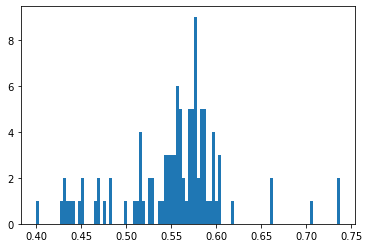

In [26]:
import matplotlib.pyplot as plt
plt.hist(Y_hat[testX.type_shot_penalty_a0.values].scores,
         bins=100)
plt.show()

In [ ]:
Y[testX.type_shot_penalty_a0].scores

In [ ]:
sum(Y[X.type_shot_penalty_a0].scores) / X.type_shot_penalty_a0.sum()

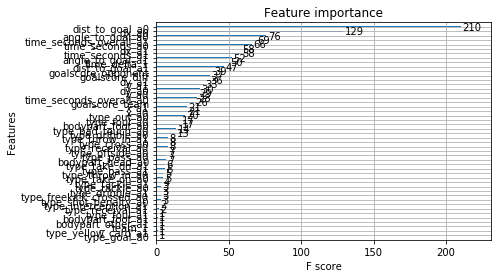

In [27]:
xgboost.plot_importance(models["scores"])

In [ ]:
%%time
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression

ebm = ExplainableBoostingClassifier(interactions=0,n_estimators=100)

#help(ebm.fit(X, Y["scores"]))
help(ebm.fit)

In [ ]:
#for col in X.columns:
#    if any(X[col].isna()):
#        print(col)
sum(X.dx_a0.isna())

In [ ]:
acs[acs.dx.isna()].action_id

### Save predictions

In [ ]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_hat],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5,f"game_{int(k)}")